In [ ]:
pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

Load libraries

In [ ]:
from bertopic import BERTopic
import io
from google.colab import files
import pandas as pd
import geopandas as gpd
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer

#Loading Data and merge them

In [ ]:
osm_uploaded = files.upload()
wiki_uploaded = files.upload()

Saving kc_osm_data2.csv to kc_osm_data2.csv


Saving kc_wiki_with_summary.csv to kc_wiki_with_summary.csv


In [ ]:
#read file
kc_wiki= pd.read_csv(io.BytesIO(wiki_uploaded['kc_wiki_with_summary.csv']))
kc_osm = pd.read_csv(io.BytesIO(osm_uploaded['kc_osm_data2.csv']), index_col=0)
#convert osm data to geopandas dataframe
import shapely.wkt
kc_osm['geometry.coordinates'] = gpd.GeoSeries.from_wkt(kc_osm["geometry.coordinates"])
kc_osm = gpd.GeoDataFrame(kc_osm, geometry = 'geometry.coordinates',
                                  crs="EPSG:4326").to_crs('epsg:27700')
kc_osm = kc_osm.rename(columns={'geometry.coordinates': 'geometry'})
#select certain columns from wiki data
kc_wiki = kc_wiki[["gt_page_id",
                   "gt_lon",
                   "gt_lat",
                   "geometry",
                   "page_title",
                   "page_summary"]]
#set geometry for wiki data
kc_wiki = gpd.GeoDataFrame(kc_wiki,
                           geometry=gpd.points_from_xy(kc_wiki.gt_lon,
                                                       kc_wiki.gt_lat),
                                                       crs="EPSG:4326").to_crs('epsg:27700')
#join dataframes
osm_wiki_kc = pd.concat([kc_osm, kc_wiki], ignore_index=True, sort=False)

In [ ]:
#remove duplicates
osm_wiki_kc = osm_wiki_kc.drop_duplicates(subset=['geometry'])
osm_wiki_kc

,geometry,properties.@osmId,key,value,gt_page_id,gt_lon,gt_lat,page_title,page_summary
0,POINT (525513.355 179469.956),node/376496924,properties.amenity,post_box,NaN,NaN,NaN,NaN,NaN
1,POINT (525524.147 179440.713),node/1291086772,properties.amenity,parking_entrance,NaN,NaN,NaN,NaN,NaN
2,POINT (525501.001 179494.131),node/1291086833,properties.amenity,dentist,NaN,NaN,NaN,NaN,NaN
3,POINT (525495.908 179508.56),node/1291086846,properties.amenity,dentist,NaN,NaN,NaN,NaN,NaN
4,POINT (525419.741 179152.791),node/376497068,properties.amenity,post_box,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6558,POINT (525026.515 179415.612),NaN,NaN,NaN,1619245.0,-0.200180,51.499860,Commonwealth_Institute,The Commonwealth Education Trust is a regist...
6559,POINT (524713.984 180491.72),NaN,NaN,NaN,94200.0,-0.204300,51.509600,Notting_Hill,"Notting Hill is a district of West London, Eng..."
6560,POINT (527720.762 177717.772),NaN,NaN,NaN,1702541.0,-0.162000,51.484000,Chelsea_Embankment,Chelsea Embankment is part of the Thames Emban...
6561,POINT (526995.135 179109.066),NaN,NaN,NaN,1703553.0,-0.171944,51.496667,Gilbert_Collection,The Rosalinde and Arthur Gilbert Collection is...


Perform DBSCAN for a combined dataset of osm and wiki

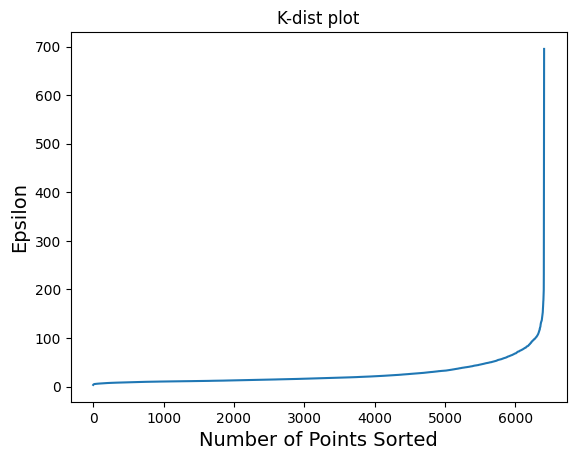

In [ ]:
from shapely.geometry import MultiPoint
osm_wiki_kc['easting'] = osm_wiki_kc['geometry'].x
osm_wiki_kc['northing'] = osm_wiki_kc['geometry'].y
kc_coords = osm_wiki_kc[['easting', 'northing']].to_numpy()
#finding the optimum epsilon
#Codes inspired from Medium post by Tara Mullin (2020), titled : DBSCAN Parameter Estimation Using Python
#Available at: https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(kc_coords)
distances, indices = neighbors_fit.kneighbors(kc_coords)
distances = np.sort(distances, axis=0)
distances = distances[:,3]
plt.title('K-dist plot')
plt.xlabel('Number of Points Sorted', fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.plot(distances)

In [ ]:
#run dbscan
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=50, min_samples=4, metric='euclidean')
db = dbscan.fit(kc_coords)
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
num_noise = list(cluster_labels).count(-1)
print(num_clusters)
print(num_noise)

139
533


In [ ]:
#add cluster labels to dataset
osm_wiki_kc['cluster'] = cluster_labels
#remove noise
remove = osm_wiki_kc[osm_wiki_kc['cluster'] == -1].index
osm_wiki_kc2 = osm_wiki_kc.drop(remove)

Get tag list for each dbscan cluster as a list

In [ ]:
#for OSM
osm_kc_dbscan_only = osm_wiki_kc2.dropna(subset=['value'])
osm_kc_dbscan_new = pd.DataFrame(osm_kc_dbscan_only.groupby('cluster')['value'].apply(list))
#for wiki
wiki_kc_dbscan_only = osm_wiki_kc.dropna(subset=['page_title'])

Regionalization

[<POLYGON ((525234.724 179146.318, 524896.428 179222.286, 524964.683 179686.6...>, <POLYGON ((524683.755 179053.676, 524666.744 179085.761, 524699.912 179125.5...>, <POLYGON ((524812.287 179134.563, 524818.309 179142.756, 524834.886 179158.0...>, <POLYGON ((524555.666 178976.909, 524559.56 179013.869, 524606.332 179101.67...>, <POLYGON ((525475.752 179045.95, 525478.455 179049.844, 525499.303 179077.52...>, <POLYGON ((526343.288 178617.139, 525986.665 178709.932, 525698.086 178849.4...>, <POLYGON ((525178.734 178644.206, 525119.373 178705.224, 525186.65 178778.62...>, <POLYGON ((524923.62 178770.947, 524923.274 178809.672, 525012.803 178834.60...>, <POLYGON ((525579.857 179314.282, 525551.464 179365.812, 525602.437 179379.4...>, <POLYGON ((525251.439 179009.109, 525230.5 179070.527, 525261.143 179071.37,...>, <POLYGON ((525593.48 178968.807, 525600.446 178982.577, 525608.326 178992.56...>, <POLYGON ((526132.877 177142.326, 526117.57 177168.407, 526110.657 177182.95...>, <POLYGON ((5264

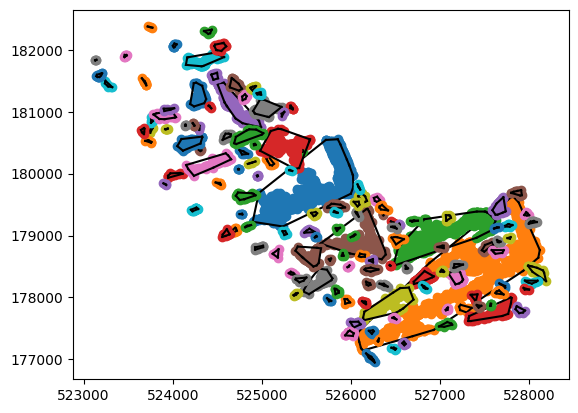

In [ ]:
#create convex hull
#Reference The Scipy Community, Available at: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html
import scipy
import numpy
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt

#select only necessary column
db_cl = osm_wiki_kc2[["easting",
                   "northing",
                   "cluster"]]
#remove noise
remove = db_cl[db_cl['cluster'] == -1].index
db_cl = db_cl.drop(remove)

#run convexhull for each clusters seperately
#create a list of convex hull
h = [] #for list of polygon coordinates from chull
for i in range(0,138):
    cluster_i = db_cl.loc[db_cl['cluster']==i]
    db_cl_i = cluster_i[["easting", "northing"]].to_numpy()
    ch_i = ConvexHull(db_cl_i)
    h.append(db_cl_i[ch_i.vertices,:].tolist())
    plt.plot(db_cl_i[:, 0],db_cl_i[:, 1],  'o')
    for simplex in ch_i.simplices:
        ploted=plt.plot(db_cl_i[simplex, 0], db_cl_i[simplex, 1],'k-')

from shapely.geometry import MultiPoint
c_h = []
for hull in h:
    c_h.append(MultiPoint(hull).convex_hull)

print(c_h)



In [ ]:
osm_kc_dbscan_new.to_csv('osm_kc_dbscan_new.csv')
files.download('osm_kc_dbscan_new.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Import BTM topics for OSM

In [ ]:
#import btm topics from osm_kc
osm_btm_uploaded = files.upload()


Saving topic_prob_kc_osm_new.csv to topic_prob_kc_osm_new.csv


In [ ]:
osm_btm= pd.read_csv(io.BytesIO(osm_btm_uploaded['topic_prob_kc_osm_new.csv']))

In [ ]:
#Name the btm topics
def get_osm_topic_name(topic):
    if topic == 'V1':
        return 'Urban Park & Green Space'
    elif topic == 'V2':
        return 'Local Shopping Street'
    elif topic == 'V3':
        return 'Local Shopping Street'
    elif topic == 'V4':
        return 'Vehicle Parking Zone'
    elif topic == 'V5':
        return 'Eateries'
    elif topic == 'V6':
        return 'Commercial Services and Diplomatic Mission'
    elif topic == 'V7':
        return 'Commercial Services and Diplomatic Mission'
    elif topic == 'V8':
        return 'High Street Shopping'
    elif topic == 'V9':
        return 'Vehicle Parking Zone'
    else:
        return 'Sports facilities, Gallery & Artwork'

In [ ]:
osm_btm['Topic_Name_OSM'] = osm_btm['Topic'].apply(get_osm_topic_name)

In [ ]:
#merge
kc_osm =  pd.merge(osm_kc_dbscan_only, osm_btm, on = 'cluster')

In [ ]:
kc_osm.to_csv('osm_btm_with_topic_names.csv')
files.download('osm_btm_with_topic_names.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#join dataframes
osm_btm_wiki = pd.concat([kc_osm, wiki_kc_dbscan_only], ignore_index=True, sort=False)
osm_btm_wiki

,geometry,properties.@osmId,key,value,gt_page_id,gt_lon,gt_lat,page_title,page_summary,easting,...,V3,V4,V5,V6,V7,V8,V9,V10,Topic,Topic_Name_OSM
0,POINT (525513.355 179469.956),node/376496924,properties.amenity,post_box,NaN,NaN,NaN,NaN,NaN,525513.355296,...,0.174998,0.084089,0.196455,0.017333,0.031249,0.055461,0.061265,0.026488,V2,Local Shopping Street
1,POINT (525524.147 179440.713),node/1291086772,properties.amenity,parking_entrance,NaN,NaN,NaN,NaN,NaN,525524.147298,...,0.174998,0.084089,0.196455,0.017333,0.031249,0.055461,0.061265,0.026488,V2,Local Shopping Street
2,POINT (525501.001 179494.131),node/1291086833,properties.amenity,dentist,NaN,NaN,NaN,NaN,NaN,525501.000899,...,0.174998,0.084089,0.196455,0.017333,0.031249,0.055461,0.061265,0.026488,V2,Local Shopping Street
3,POINT (525495.908 179508.56),node/1291086846,properties.amenity,dentist,NaN,NaN,NaN,NaN,NaN,525495.908385,...,0.174998,0.084089,0.196455,0.017333,0.031249,0.055461,0.061265,0.026488,V2,Local Shopping Street
4,POINT (524683.755 179053.676),node/885331227,properties.amenity,bicycle_rental,NaN,NaN,NaN,NaN,NaN,524683.754683,...,0.112400,0.044762,0.334049,0.006483,0.026352,0.068266,0.386006,0.020388,V9,Vehicle Parking Zone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5943,POINT (525026.515 179415.612),NaN,NaN,NaN,1619245.0,-0.200180,51.499860,Commonwealth_Institute,The Commonwealth Education Trust is a regist...,525026.515397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5944,POINT (524713.984 180491.72),NaN,NaN,NaN,94200.0,-0.204300,51.509600,Notting_Hill,"Notting Hill is a district of West London, Eng...",524713.984193,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5945,POINT (527720.762 177717.772),NaN,NaN,NaN,1702541.0,-0.162000,51.484000,Chelsea_Embankment,Chelsea Embankment is part of the Thames Emban...,527720.762208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5946,POINT (526995.135 179109.066),NaN,NaN,NaN,1703553.0,-0.171944,51.496667,Gilbert_Collection,The Rosalinde and Arthur Gilbert Collection is...,526995.134870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Run Bertopic on wiki summary

In [ ]:
#extract only wiki data first
summary_kc = kc_wiki['page_summary'].tolist()
#run model
#Reference: Maarten Grootendorst(2022)
#Available at: https://github.com/MaartenGr/BERTopic
#extract embeddings
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
#reduce dimension
from umap import UMAP
umap_model = UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine')
#clustering
from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size = 4, min_samples = 3,
                        gen_min_span_tree = True,
                        prediction_data = True)

#Tokenize topics
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words="english")
# Create topic representation
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer()
topic_model = BERTopic( embedding_model=embedding_model,
                        umap_model=umap_model,
                        hdbscan_model=hdbscan_model,
                        vectorizer_model=cv,
                        ctfidf_model=ctfidf_model,
                        nr_topics=10,
                        language="english",
                        calculate_probabilities=True,
                        verbose=True)
topics, probs = topic_model.fit_transform(summary_kc)

2025-03-13 12:35:58,534 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2025-03-13 12:36:19,190 - BERTopic - Embedding - Completed ✓
2025-03-13 12:36:19,193 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-13 12:36:19,432 - BERTopic - Dimensionality - Completed ✓
2025-03-13 12:36:19,433 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-13 12:36:19,468 - BERTopic - Cluster - Completed ✓
2025-03-13 12:36:19,469 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-13 12:36:19,544 - BERTopic - Representation - Completed ✓
2025-03-13 12:36:19,545 - BERTopic - Topic reduction - Reducing number of topics
2025-03-13 12:36:19,605 - BERTopic - Topic reduction - Reduced number of topics from 27 to 10


In [ ]:
topic_wiki = pd.DataFrame(topic_model.get_document_info(summary_kc))
topic_model.visualize_barchart(top_n_topics = 11)

In [ ]:
topic_model.generate_topic_labels()

['-1_street_house_road',
 '0_london_kensington_street',
 '1_embassy_kingdom_diplomatic',
 '2_museum_science_victoria',
 '3_notting_hill_season',
 '4_school_academy_education',
 '5_boutique_shop_hendrix',
 '6_tom_department_store',
 '7_restaurant_michelin_indian',
 '8_gallery_art_collection']

In [ ]:
def get_topic_name(topic):
    if topic == 0:
        return 'Renowned roads and streets'
    elif topic == 1:
        return 'Embassy and Diplomatic zone'
    elif topic == 2:
        return 'Museum and Exhibition'
    elif topic == 3:
        return 'Others'
    elif topic == 4:
        return 'Educational Institutes'
    elif topic == 5:
        return 'Boutique and Fashion Shopping'
    elif topic == 6:
        return 'Others'
    elif topic == 7:
        return 'Eateries'
    elif topic == 8:
        return 'Museum and Exhibition'
    else:
        return 'Mixed Functions'

In [ ]:
topic_wiki['Topic_Name_Wiki'] = topic_wiki['Topic'].apply(get_topic_name)

In [ ]:
# Merge wiki topic by index
kc_wiki_topic = pd.merge(kc_wiki, topic_wiki, left_index=True, right_index=True)
kc_wiki_topic = gpd.GeoDataFrame(kc_wiki_topic, geometry = kc_wiki_topic["geometry"])

Integrate two topic type

In [ ]:
#merge with osm_btm and wiki_bertopic
#merged_gdf = gpd.sjoin(osm_wiki_kc, kc_wiki_topic, how="left")
osm_btm_wiki = gpd.GeoDataFrame(osm_btm_wiki, geometry = osm_btm_wiki["geometry"])
merged_gdf = gpd.sjoin(osm_btm_wiki, kc_wiki_topic, how="left")
list(merged_gdf)
#select certain columns from wiki data
merged_gdf_fil = merged_gdf[[
                   "geometry",
                   "easting",
                   "northing",
                   "Topic_Name_OSM",
                   "Topic_Name_Wiki",
                   "cluster"]]
merged_gdf_fil

,geometry,easting,northing,Topic_Name_OSM,Topic_Name_Wiki,cluster
0,POINT (525513.355 179469.956),525513.355296,179469.956091,Local Shopping Street,NaN,0
1,POINT (525524.147 179440.713),525524.147298,179440.713168,Local Shopping Street,NaN,0
2,POINT (525501.001 179494.131),525501.000899,179494.130977,Local Shopping Street,NaN,0
3,POINT (525495.908 179508.56),525495.908385,179508.559658,Local Shopping Street,NaN,0
4,POINT (524683.755 179053.676),524683.754683,179053.676139,Vehicle Parking Zone,NaN,1
...,...,...,...,...,...,...
5943,POINT (525026.515 179415.612),525026.515397,179415.612141,NaN,Educational Institutes,0
5944,POINT (524713.984 180491.72),524713.984193,180491.720266,NaN,Others,82
5945,POINT (527720.762 177717.772),527720.762208,177717.771881,NaN,Renowned roads and streets,53
5946,POINT (526995.135 179109.066),526995.134870,179109.066390,NaN,Museum and Exhibition,12


In [ ]:
#remove the noise cluster
remove = merged_gdf_fil[merged_gdf_fil['cluster'] == -1].index
merged_gdf_fil = merged_gdf_fil.drop(remove)

In [ ]:
#Create one column for topic label
merged_gdf_fil['Topic'] = merged_gdf_fil['Topic_Name_OSM'].where(merged_gdf_fil['Topic_Name_Wiki'].isna(),
                                                                 merged_gdf_fil['Topic_Name_Wiki'])

merged_gdf_fil

,geometry,easting,northing,Topic_Name_OSM,Topic_Name_Wiki,cluster,Topic
0,POINT (525513.355 179469.956),525513.355296,179469.956091,Local Shopping Street,NaN,0,Local Shopping Street
1,POINT (525524.147 179440.713),525524.147298,179440.713168,Local Shopping Street,NaN,0,Local Shopping Street
2,POINT (525501.001 179494.131),525501.000899,179494.130977,Local Shopping Street,NaN,0,Local Shopping Street
3,POINT (525495.908 179508.56),525495.908385,179508.559658,Local Shopping Street,NaN,0,Local Shopping Street
4,POINT (524683.755 179053.676),524683.754683,179053.676139,Vehicle Parking Zone,NaN,1,Vehicle Parking Zone
...,...,...,...,...,...,...,...
5942,POINT (524888.26 179678.463),524888.259756,179678.462641,NaN,Renowned roads and streets,72,Renowned roads and streets
5943,POINT (525026.515 179415.612),525026.515397,179415.612141,NaN,Educational Institutes,0,Educational Institutes
5944,POINT (524713.984 180491.72),524713.984193,180491.720266,NaN,Others,82,Others
5945,POINT (527720.762 177717.772),527720.762208,177717.771881,NaN,Renowned roads and streets,53,Renowned roads and streets


Organise clusters based on number of each OSM_BTM topics and Wiki BERTopic

In [ ]:
#pivot osm tags
merged_gdf3 = (
    pd.melt(merged_gdf_fil,
            id_vars=['cluster'],
            value_vars = ['Topic'])
      .pivot_table(columns='value',
                    aggfunc='count',
                    index='cluster',
                    values='value',
                    fill_value=0)
       )
merged_gdf3.columns.name = None
merged_gdf3

,Boutique and Fashion Shopping,Commercial Services and Diplomatic Mission,Eateries,Educational Institutes,Embassy and Diplomatic zone,High Street Shopping,Local Shopping Street,Mixed Functions,Museum and Exhibition,Others,Renowned roads and streets,"Sports facilities, Gallery & Artwork",Urban Park & Green Space,Vehicle Parking Zone
cluster,,,,,,,,,,,,,,
0,1,0,1,1,0,0,860,2,2,3,12,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,13
2,0,0,10,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,15
4,0,0,0,0,1,0,0,0,0,0,0,0,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,0,0,0,0,0,0,0,0,0,0,0,0,0,4
134,0,0,0,0,0,0,6,0,0,0,0,0,0,0
135,0,0,0,0,0,0,5,0,0,0,0,0,0,0


In [ ]:
#summary stat for each column
merged_gdf3.describe()

,Boutique and Fashion Shopping,Commercial Services and Diplomatic Mission,Eateries,Educational Institutes,Embassy and Diplomatic zone,High Street Shopping,Local Shopping Street,Mixed Functions,Museum and Exhibition,Others,Renowned roads and streets,"Sports facilities, Gallery & Artwork",Urban Park & Green Space,Vehicle Parking Zone
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,0.043478,0.492754,21.420290,0.050725,0.108696,3.688406,9.811594,0.188406,0.115942,0.101449,0.710145,0.021739,0.224638,5.666667
std,0.359837,2.639527,118.678478,0.251200,0.413014,17.627037,76.935137,0.586350,0.888470,0.440468,2.352830,0.255377,1.489712,10.374965
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,7.000000
max,4.000000,28.000000,1231.000000,2.000000,2.000000,149.000000,860.000000,5.000000,10.000000,3.000000,21.000000,3.000000,15.000000,78.000000


In [ ]:
#standardise data
from sklearn.preprocessing import StandardScaler
sca = StandardScaler()
cow_std = sca.fit_transform(merged_gdf3)
from sklearn.decomposition import PCA
#check for optimum number of components
#ref: By Bala Priya C (2023), titled: Principal Component Analysis with Scikit-Learn
#Available at: https://www.kdnuggets.com/2023/05/principal-component-analysis-pca-scikitlearn.html
import numpy as np
nums = np.arange(15)
variance_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit_transform(cow_std)
  variance_ratio.append(np.sum(pca.explained_variance_ratio_))


Text(0, 0.5, 'Explained variance ratio')

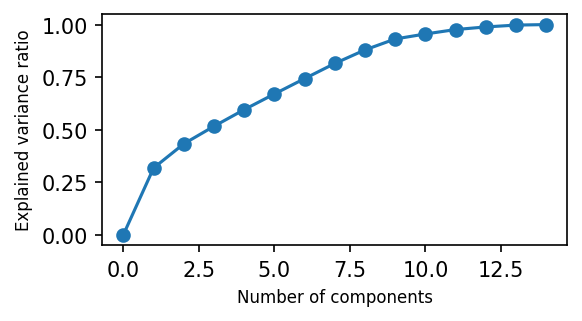

In [ ]:
#plot variance ratio for different component size
import matplotlib.pyplot as plt
plt.figure(figsize=(4,2),dpi=150)
#plt.grid()
plt.plot(nums,variance_ratio,marker='o')
plt.xlabel('Number of components', fontsize=8)
plt.ylabel('Explained variance ratio', fontsize=8)
#plt.title('No. of components vs. Explained Variance Ratio')

In [ ]:
#dimension reduction
pca = PCA(n_components=12)
cow_dr = pd.DataFrame(pca.fit_transform(cow_std))

Run clustering on the resultant dataset

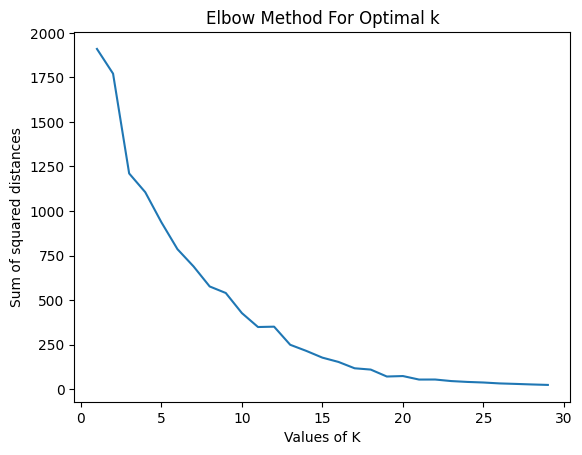

In [ ]:
x_array = cow_dr.values.tolist()
#determine optimum number of k for k-means clustering
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
Sum_of_squared_distances = []
K = range(1,30)
for cluster_no in K :
 kmeans = KMeans(n_clusters=cluster_no)
 kmeans.fit(x_array)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances)
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
#run k-means
kmeans2 = KMeans(n_clusters=12, random_state=0).fit(x_array)
label = kmeans2.fit_predict(x_array)
#join the cluster label to each dbscan cluster
import numpy as np
merged_gdf3['k_means_cluster'] = np.array(label)
merged_gdf3

,Boutique and Fashion Shopping,Commercial Services and Diplomatic Mission,Eateries,Educational Institutes,Embassy and Diplomatic zone,High Street Shopping,Local Shopping Street,Mixed Functions,Museum and Exhibition,Others,Renowned roads and streets,"Sports facilities, Gallery & Artwork",Urban Park & Green Space,Vehicle Parking Zone,k_means_cluster
cluster,,,,,,,,,,,,,,,
0,1,0,1,1,0,0,860,2,2,3,12,0,0,0,4
1,0,0,0,0,0,0,0,0,0,0,0,0,0,13,2
2,0,0,10,0,0,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,0,0,0,15,2
4,0,0,0,0,1,0,0,0,0,0,0,0,0,21,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2
134,0,0,0,0,0,0,6,0,0,0,0,0,0,0,2
135,0,0,0,0,0,0,5,0,0,0,0,0,0,0,2


Visualize k-clusters (spatial and non-spatial)

Heatmap Visualisation

In [ ]:
import pandas as pd
K_clusters = merged_gdf3.pivot_table(
                            index= 'k_means_cluster',
                            aggfunc="sum")

In [ ]:
K_clusters

,Boutique and Fashion Shopping,Commercial Services and Diplomatic Mission,Eateries,Educational Institutes,Embassy and Diplomatic zone,High Street Shopping,Local Shopping Street,Mixed Functions,Museum and Exhibition,Others,Renowned roads and streets,"Sports facilities, Gallery & Artwork",Urban Park & Green Space,Vehicle Parking Zone
k_means_cluster,,,,,,,,,,,,,,
0,0,0,0,0,0,0,350,0,0,8,4,0,0,62
1,0,5,170,0,0,51,8,13,0,0,16,0,0,249
2,1,35,658,3,4,194,136,0,1,0,33,0,16,451
3,0,0,535,2,1,0,0,2,10,0,7,0,0,0
4,1,0,1,1,0,0,860,2,2,3,12,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1,3,0,0
6,4,0,1231,1,2,0,0,5,2,0,21,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,15,0
8,0,28,0,0,0,0,0,1,0,0,2,0,0,0


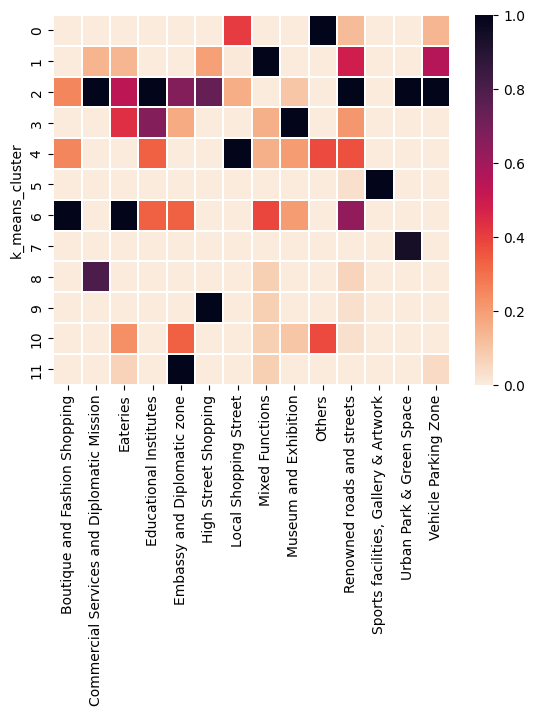

In [ ]:
#standardize data (z-score normalisation)
#new_k_clusters = (K_clusters - K_clusters.mean())/K_clusters.std()
#min-max
new_k_clusters = (K_clusters - K_clusters.min())/(K_clusters.max() - K_clusters.min())
import seaborn as sns
k_heatmap = sns.heatmap(new_k_clusters,
                        cmap = 'rocket_r',
                        linewidths = 0.08)

Spatial representation

In [ ]:
merged_gdf5 = pd.merge(merged_gdf3,
                       merged_gdf_fil.groupby('cluster')['geometry'].apply(list),
                       on = 'cluster')
merged_gdf5

,Boutique and Fashion Shopping,Commercial Services and Diplomatic Mission,Eateries,Educational Institutes,Embassy and Diplomatic zone,High Street Shopping,Local Shopping Street,Mixed Functions,Museum and Exhibition,Others,Renowned roads and streets,"Sports facilities, Gallery & Artwork",Urban Park & Green Space,Vehicle Parking Zone,k_means_cluster,geometry
cluster,,,,,,,,,,,,,,,,
0,1,0,1,1,0,0,860,2,2,3,12,0,0,0,4,"[POINT (525513.3552961448 179469.95609114587),..."
1,0,0,0,0,0,0,0,0,0,0,0,0,0,13,2,"[POINT (524683.7546826897 179053.67613929207),..."
2,0,0,10,0,0,0,0,0,0,0,0,0,0,0,2,"[POINT (524818.3092164188 179142.7559467503), ..."
3,0,0,0,0,0,0,0,0,0,0,0,0,0,15,2,"[POINT (524555.6658644185 178976.909243548), P..."
4,0,0,0,0,1,0,0,0,0,0,0,0,0,21,2,"[POINT (525575.6863612995 179069.168958359), P..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2,"[POINT (527934.4047212913 178153.1352190816), ..."
134,0,0,0,0,0,0,6,0,0,0,0,0,0,0,2,"[POINT (524944.5157560743 179967.8399941899), ..."
135,0,0,0,0,0,0,5,0,0,0,0,0,0,0,2,"[POINT (525764.2425398994 178593.3223985823), ..."


In [ ]:
cluster_info = merged_gdf3[['k_means_cluster']]

In [ ]:
##add c_h polygon coordinates
cluster_info['geometry'] = c_h
#set index as column
cluster_info['cluster'] = cluster_info.index

In [ ]:
cluster_info

,k_means_cluster,geometry,cluster
cluster,,,
0,4,POLYGON ((525234.7242163775 179146.31764191616...,0
1,2,POLYGON ((524683.7546826897 179053.67613929207...,1
2,2,"POLYGON ((524812.2873244482 179134.5632284424,...",2
3,2,"POLYGON ((524555.6658644185 178976.909243548, ...",3
4,2,"POLYGON ((525475.751724326 179045.95000695804,...",4
...,...,...,...
133,2,POLYGON ((527996.3606161022 178126.77517435665...,133
134,2,"POLYGON ((524948.4482268306 179957.8665645516,...",134
135,2,"POLYGON ((525764.2425398994 178593.3223985823,...",135


In [ ]:
#add topic labels
def get_integ_topic_name(topic):
    if topic == 0:
        return 'Local Shopping Street'
    elif topic == 1:
        return 'Mixed Functions'
    elif topic == 2:
        return 'Mixed Functions'
    elif topic == 3:
        return 'Tourism'
    elif topic == 4:
        return 'Local Shopping Street'
    elif topic == 5:
        return 'Sports-facilities, Gallery & Artwork'
    elif topic == 6:
        return 'Boutique and Fashion street'
    elif topic == 7:
        return 'Park & Green Space'
    elif topic == 8:
        return 'Diplomatic Zone'
    elif topic == 9:
        return 'High Street Shopping'
    elif topic == 10:
        return 'Others'
    else:
        return 'Diplomatic Zone'
cluster_info['Integ_Topic'] = cluster_info['k_means_cluster'].apply(get_integ_topic_name)

In [ ]:
cluster_info.index.names = ['no']

In [ ]:
cluster_info.to_csv('k_cluster_integ.csv')
files.download('k_cluster_integ.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

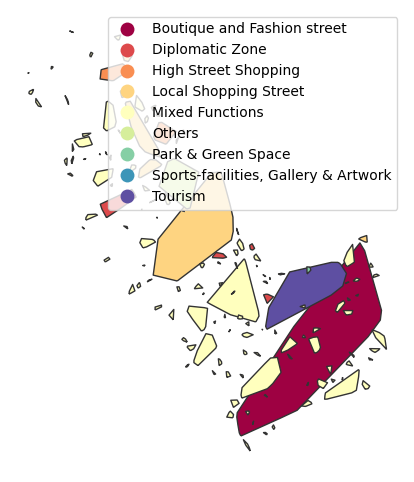

In [ ]:
#Map
import geopandas as gpd
#Mapping
cluster_info = gpd.GeoDataFrame(cluster_info, geometry="geometry", crs='EPSG:27700')
# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
#kc_boundary.to_crs(epsg=4326).plot(ax=ax,
                                  #color= 'lightgrey', alpha= 0.2,
                                  #edgecolor = '0.5')
cluster_info.plot(column='Integ_Topic',
                      categorical = True  ,
                      edgecolor='0.2',
                      cmap='Spectral',
                      ax=ax,
                      legend = True
                      #legend_kwds={'label': "K-means Cluster", 'orientation': 'vertical'}
                     )
ax.set_axis_off()
